<a href="https://colab.research.google.com/github/johnsunbuns/Convultional-Neural-Network/blob/master/CNN_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='root/cifar',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='root/cifar',
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True)

Extracting root/cifar/cifar-10-python.tar.gz to root/cifar
Files already downloaded and verified


In [ ]:
x, y = next(iter(train_dataset))
print(x.shape)
print(x.permute(1,2,0).shape)
print(f'Class of this image is {y}')

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])
Class of this image is 6


In [ ]:
def plot_images(dataset, num):
  fig = plt.figure(figsize=(3*num, 3*num))
  iterator = iter(dataset)
  for i in range(num):
    images, labels = next(iterator)
    sub = fig.add_subplot(1, num, i + 1)
    sub.axis('off')
    sub.imshow(images.permute((1,2,0)), interpolation='nearest')

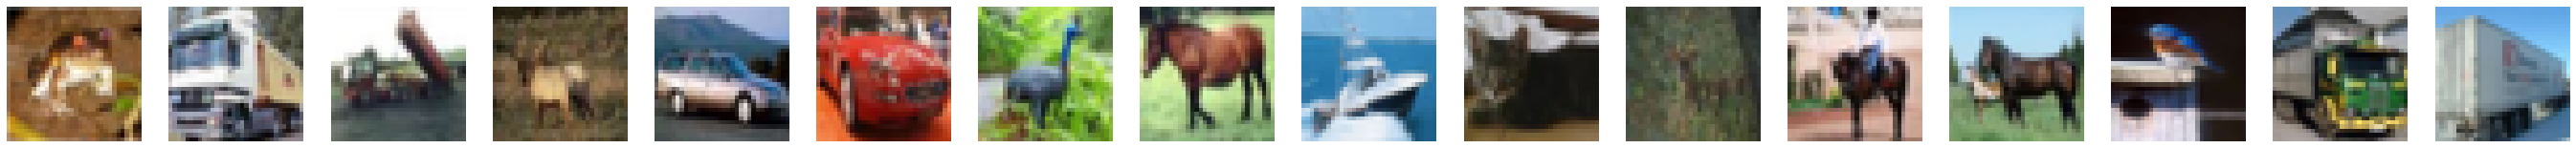

In [ ]:
plot_images(train_dataset, 16)

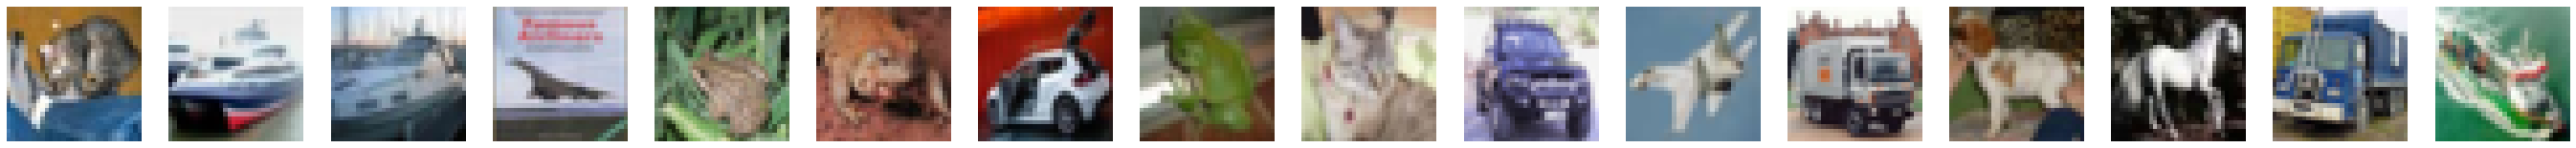

In [ ]:
plot_images(test_dataset, 16)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False, num_workers=1)

In [ ]:
x, y = next(iter(train_dataloader))
print(x.shape)
print(y.shape)
print(len(train_dataloader))

torch.Size([100, 3, 32, 32])
torch.Size([100])
500


In [ ]:
class ConvNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1)

    self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1)
    self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1)

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(in_features=24*5*5, out_features=100)
    self.fc2 = nn.Linear(in_features=100, out_features=100)
    self.out = nn.Linear(in_features=100, out_features=10)

  def forward(self, x):
    x = (F.relu(self.conv1(x)))
    x = self.max_pool(F.relu(self.conv2(x)))
    x = (F.relu(self.conv3(x)))
    x = self.max_pool(F.relu(self.conv4(x)))

    x = x.view(-1, 24*5*5) # flatten
    x = F.relu(self.fc1(x)) # Dense
    x = F.relu(self.fc2(x)) # Dense
    output = self.out(x)
    return output

In [ ]:
conv1 = nn.Conv2d(3, 12, 3)
conv2 = nn.Conv2d(12, 12, 3)
conv3 = nn.Conv2d(12, 24, 3)
conv4 = nn.Conv2d(24, 24, 3)
pool = nn.MaxPool2d(2, 2)

In [ ]:
x = torch.ones(100, 3, 32, 32)

x = conv1(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv3(x)
print(x.shape)
x = conv4(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([100, 12, 30, 30])
torch.Size([100, 12, 28, 28])
torch.Size([100, 12, 14, 14])
torch.Size([100, 24, 12, 12])
torch.Size([100, 24, 10, 10])
torch.Size([100, 24, 5, 5])


In [ ]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

True


device(type='cuda')

In [ ]:
num_epochs = 10
# learning_rate = .001
# num_totalsteps = len(train_dataloader)

# model = ConvNetwork().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'epoch: {epoch+1}/{num_epochs}, loss: {loss:.4f}')

epoch: 1/10, loss: 0.5926
epoch: 2/10, loss: 0.5479
epoch: 3/10, loss: 0.6340
epoch: 4/10, loss: 0.5322
epoch: 5/10, loss: 0.6152
epoch: 6/10, loss: 0.5940
epoch: 7/10, loss: 0.5528
epoch: 8/10, loss: 0.8170
epoch: 9/10, loss: 0.7826
epoch: 10/10, loss: 0.5242


In [ ]:
batch_size=100

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in train_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)

    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]
      if label == pred:
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  accuracy = n_correct/n_samples * 100
  print(f'Training Accuracy: {accuracy}%')

  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in test_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)

    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]
      if label == pred:
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  accuracy = n_correct/n_samples * 100
  print(f'Testing Accuracy: {accuracy}%')

Training Accuracy: 81.77600000000001%
Testing Accuracy: 66.05%


## Visualization

In [ ]:
x, y = next(iter(test_dataloader))
y[:16]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])

In [ ]:
predictions = torch.argmax(model(x[:16].to(device)), dim=1)
predictions

tensor([3, 8, 8, 0, 4, 6, 1, 6, 5, 1, 0, 9, 5, 7, 9, 9], device='cuda:0')

In [ ]:
class_dictionary={
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
    }

def mapping(input):
  output = []
  x = input.tolist()
  for i in x:
    output.append(class_dictionary[i])
  return output

In [ ]:
print(f'predict: {mapping(predictions)}')
print(f'targets: {mapping(y[:16])}')

predict: ['cat', 'ship', 'ship', 'airplane', 'deer', 'frog', 'automobile', 'frog', 'dog', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'truck']
targets: ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship']


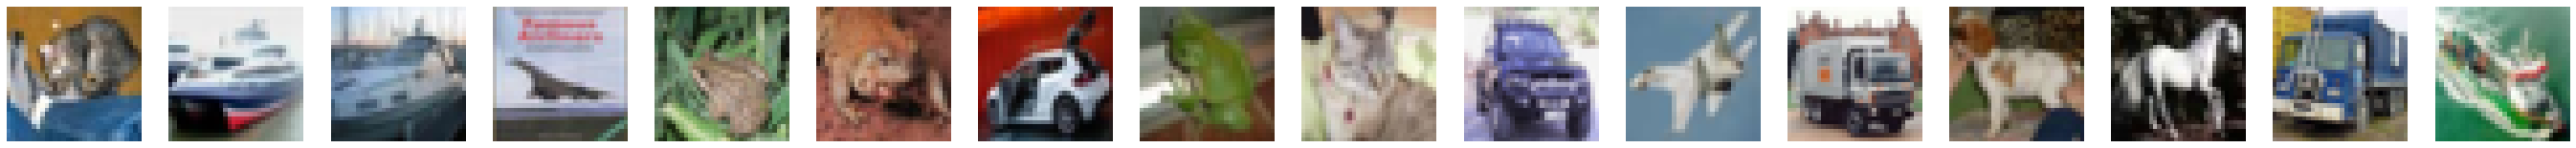

In [ ]:
plot_images(test_dataset, 16)

# Model 2.0

In [ ]:
class _ConvNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)


    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv_bn1 = nn.BatchNorm2d(64)
    self.conv_bn2 = nn.BatchNorm2d(32)
    self.drop1 = nn.Dropout(p=0.3)
    self.drop2 = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(in_features=32*5*5, out_features=100)
    self.fc2 = nn.Linear(in_features=100, out_features=100)
    self.out = nn.Linear(in_features=100, out_features=10)

  def forward(self, x):
    x = F.relu(self.conv_bn1(self.conv1(x)))
    x = F.relu(self.conv_bn1(self.max_pool(self.conv2(x))))
    x = F.relu(self.conv_bn2(self.conv3(x)))
    x = F.relu(self.conv_bn2(self.max_pool(self.conv4(x))))

    x = x.view(-1, 32*5*5)

    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = F.relu(self.fc2(x)) 

    output = self.out(x)
    return output

In [ ]:
conv1 = nn.Conv2d(3, 64, 3)
conv2 = nn.Conv2d(64, 64, 3)
conv3 = nn.Conv2d(64, 32, 3)
conv4 = nn.Conv2d(32, 32, 3)
conv5 = nn.Conv2d(32, 32, 3)
pool = nn.MaxPool2d(2, 2)

x = torch.ones(100, 3, 32, 32)

x = conv1(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv3(x)
print(x.shape)
x = conv4(x)
print(x.shape)
x = conv5(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([100, 64, 30, 30])
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 14, 14])
torch.Size([100, 32, 12, 12])
torch.Size([100, 32, 10, 10])
torch.Size([100, 32, 8, 8])
torch.Size([100, 32, 4, 4])


In [ ]:
_num_epochs = 50
_learning_rate = .0005
_num_totalsteps = len(train_dataloader)

_model = _ConvNetwork().to(device)
_criterion = nn.CrossEntropyLoss()
_optimizer = optim.Adam(_model.parameters(), lr=_learning_rate, weight_decay=.015)

for epoch in range(_num_epochs):
  for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = _model(images)
    _loss = _criterion(outputs, labels)
    _optimizer.zero_grad()
    _loss.backward()
    _optimizer.step()
    
  print(f'epoch: {epoch+1}/{_num_epochs}, loss: {_loss:.4f}')

epoch: 1/50, loss: 1.0600
epoch: 2/50, loss: 1.0916
epoch: 3/50, loss: 1.0830
epoch: 4/50, loss: 0.9472
epoch: 5/50, loss: 1.0300
epoch: 6/50, loss: 0.8611
epoch: 7/50, loss: 0.7288
epoch: 8/50, loss: 0.9168
epoch: 9/50, loss: 0.7493
epoch: 10/50, loss: 0.9166
epoch: 11/50, loss: 0.6598
epoch: 12/50, loss: 0.8306
epoch: 13/50, loss: 0.8356
epoch: 14/50, loss: 0.8415
epoch: 15/50, loss: 0.6306
epoch: 16/50, loss: 0.7526
epoch: 17/50, loss: 1.0198
epoch: 18/50, loss: 0.6087
epoch: 19/50, loss: 0.8428
epoch: 20/50, loss: 0.6873
epoch: 21/50, loss: 0.6195
epoch: 22/50, loss: 0.6855
epoch: 23/50, loss: 0.7342
epoch: 24/50, loss: 0.4861
epoch: 25/50, loss: 0.8680
epoch: 26/50, loss: 0.8691
epoch: 27/50, loss: 0.6669
epoch: 28/50, loss: 0.5264
epoch: 29/50, loss: 0.6136
epoch: 30/50, loss: 0.7387
epoch: 31/50, loss: 0.8520
epoch: 32/50, loss: 0.5126
epoch: 33/50, loss: 0.5814
epoch: 34/50, loss: 0.7118
epoch: 35/50, loss: 0.5763
epoch: 36/50, loss: 0.5289
epoch: 37/50, loss: 0.7098
epoch: 38/

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in train_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = _model(images)
    predicted = torch.argmax(outputs, dim=1)

    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  accuracy = n_correct/n_samples * 100
  print(f'Training Accuracy: {accuracy}%')

  n_correct = 0
  n_samples = 0
  for images, labels in test_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = _model(images)
    predicted = torch.argmax(outputs, dim=1)

    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  accuracy = n_correct/n_samples * 100
  print(f'Testing Accuracy: {accuracy}%')

Training Accuracy: 79.67%
Testing Accuracy: 75.17%


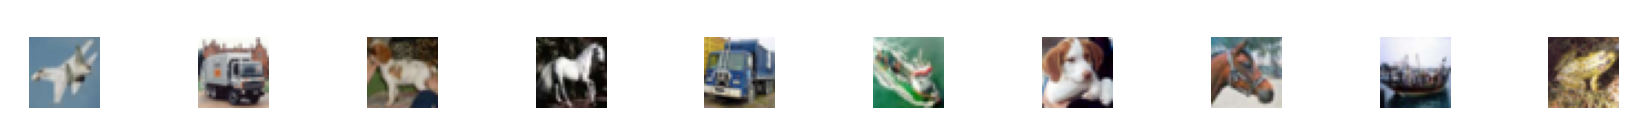

In [ ]:
class_dictionary={
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
    }

def mapping(input):
  output = []
  x = input.tolist()
  for i in x:
    output.append(class_dictionary[i])
  return output

images, labels = next(iter(test_dataloader)) # 100 for batch size
def plot_predictions(start, end):
  num_of_pics = end-start
  fig = plt.figure(figsize=(num_of_pics*3, num_of_pics*3))
  raw_predictions = torch.argmax(_model(images[start:end].to(device)), dim=1)
  processed_predictions = mapping(raw_predictions)
  processed_labels = mapping(labels[start:end])
  for i in range(num_of_pics):
    subplot = fig.add_subplot(1, num_of_pics*2, (i+1)*2)
    subplot.axis('off')
    subplot.imshow(images[start+i].permute((1,2,0)), interpolation='hanning')
    subplot.set_title(f'label: {processed_labels[i]}\npredicted: {processed_predictions[i]}',color='white')

plot_predictions(10, 20)

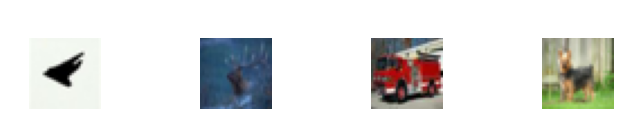

In [ ]:
images, labels = next(iter(test_dataloader))
plot_predictions(21, 25)

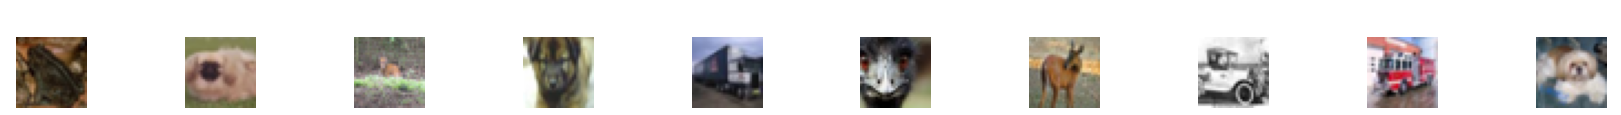

In [ ]:
plot_predictions(30, 40)

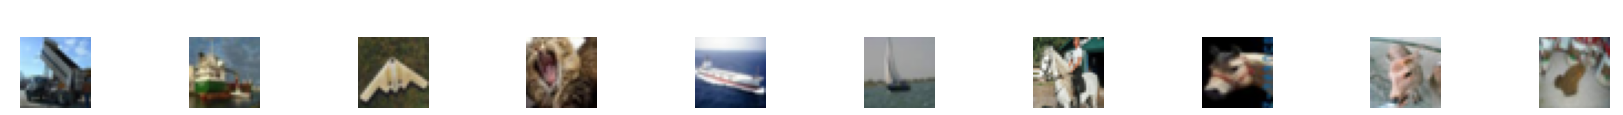

In [ ]:
plot_predictions(50, 60)

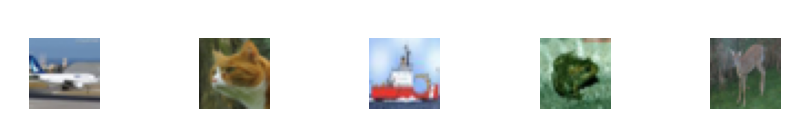

In [ ]:
images, labels = next(iter(test_dataloader))
plot_predictions(90, 95)